# London house price part 2 (exploring time series)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import fbprophet

In [111]:
# pick up from where it was left last week by loading the saved pickle file
picklefile = open('data/df_london.pickle', 'rb')
dflondon = pickle.load(picklefile)
picklefile.close()

In [17]:
# Sort df accordingly date and we only want explore property type flat
dflondon = dflondon[dflondon.property_type=='F'].sort_values('date')

In [18]:
dflondon.head(8)
# there are multiple transaction in each day

,price,date,postcode,property_type,new_or_not_new,freeholde_lease_hold,street_number,flat_number,street,area1,area2,area3,county
31217,153750,2018-01-01,NaN,F,N,L,BLOCK M,PLOT 1233,NaN,NaN,LONDON,WANDSWORTH,GREATER LONDON
69455,1344500,2018-01-02,W11 2JJ,F,N,L,70,MAISONETTE 5,ELGIN CRESCENT,NaN,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
22399,850000,2018-01-02,SW7 4RZ,F,N,L,14,REAR BASEMENT FLAT,CORNWALL MEWS SOUTH,NaN,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
47543,1000000,2018-01-02,E1W 2AG,F,Y,L,"ARIEL HOUSE, 144",APARTMENT 401,VAUGHAN WAY,NaN,LONDON,TOWER HAMLETS,GREATER LONDON
71269,380000,2018-01-02,E3 3XD,F,Y,L,"STANLEY TURNER HOUSE, 32",FLAT 407,BARRY BLANDFORD WAY,NaN,LONDON,TOWER HAMLETS,GREATER LONDON
73569,350000,2018-01-02,SW18 2HG,F,N,L,78,TOP FLAT,EAST HILL,WANDSWORTH,LONDON,WANDSWORTH,GREATER LONDON
78998,361000,2018-01-02,E14 6NF,F,N,L,64,NaN,BROWNFIELD STREET,NaN,LONDON,TOWER HAMLETS,GREATER LONDON
33639,355000,2018-01-02,SE17 3NX,F,N,L,71,NaN,COOKS ROAD,NaN,LONDON,SOUTHWARK,GREATER LONDON


In [45]:
# Let's narrow down to the desired information we want which are price and date
# Also we want to use mean to get a daily flat transaction price here, but for further exploration, let's get min, max value as well.
dfprice = dflondon.groupby('date')['price'].agg(['mean', 'max', 'min'])

In [46]:
dfprice.head()

,mean,max,min
date,,,
2018-01-01,153750.000000,153750,153750
2018-01-02,676844.642857,2630000,210500
2018-01-03,473300.043478,1850000,124000
2018-01-04,489832.339623,1850000,112500
2018-01-05,545691.738636,7950000,87980


In [47]:
# for fb prophet to work, you need to change column name.
dfprice= dfprice.reset_index()

Text(0.5,0,'')

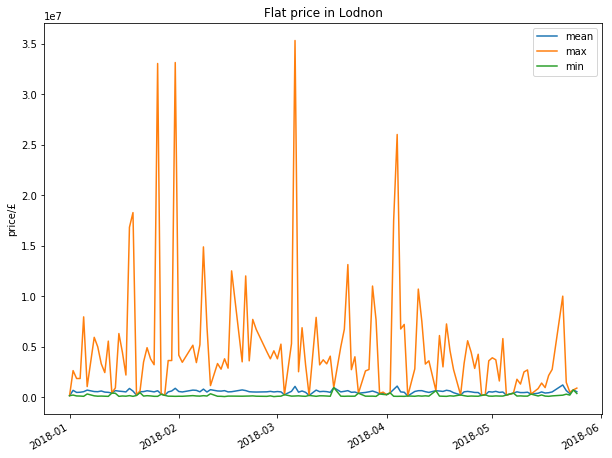

In [49]:
# Let's plot mean, maxm min
fig= dfprice.plot('date', ['mean', 'max', 'min'], kind='line', figsize=(10,8))
plt.title('Flat price in Lodnon')
plt.ylabel('price/£')
plt.xlabel('')
# it seems like the max flat price is intermittent

Text(0.5,0,'')

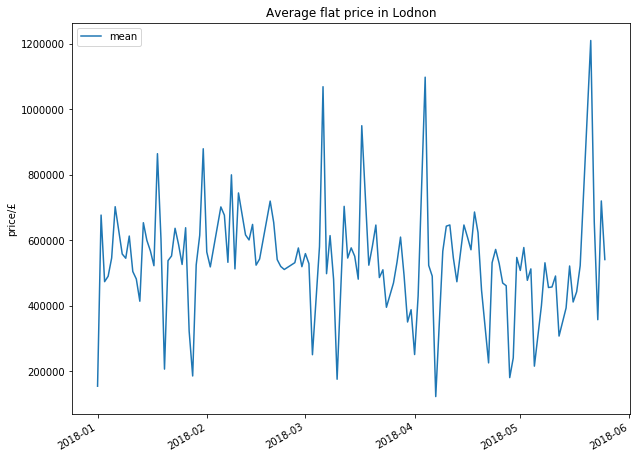

In [52]:
# try with just average
fig= dfprice.plot('date', ['mean'], kind='line', figsize=(10,8))
plt.title('Average flat price in Lodnon')
plt.ylabel('price/£')
plt.xlabel('')
# now it's more clear to see the range of average London flat prices, but still spiky

In [59]:
# smoothing the graph by calculate 7 days moving average
dfprice['roll_avg'] = dfprice['mean'].rolling(window = 7, min_periods =1).mean()

Text(0.5,0,'')

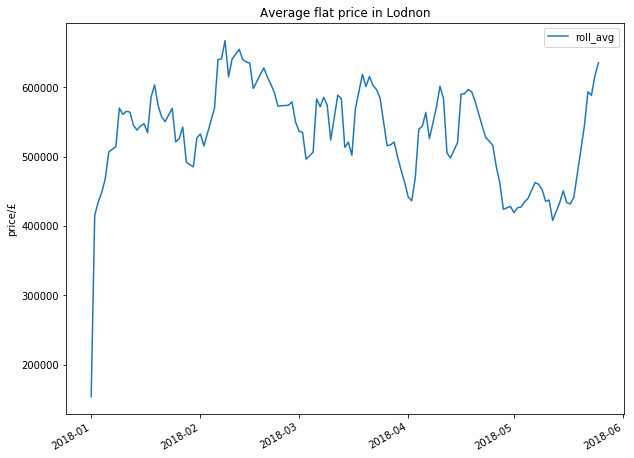

In [62]:
# try again
fig= dfprice.plot('date', ['roll_avg'], kind='line', figsize=(10,8))
plt.title('Average flat price in Lodnon')
plt.ylabel('price/£')
plt.xlabel('')
# looks much better

### start using prophot

In [79]:
dfprice.columns = ['ds', 'y', 'max', 'min', 'roll_avg']
dffbprophet = dfprice[['ds', 'y']]

In [94]:
model = fbprophet.Prophet()
model.fit(dffbprophet)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
# to make prediction, we need to make a future dataframe (try a year)
future = model.make_future_dataframe(periods=365, include_history=True)
forecast = model.predict(future)

In [96]:
# sucessfully done
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,546640.151927,404941.818983,784899.912317,546640.151927,546640.151927,50375.130429,50375.130429,50375.130429,50375.130429,50375.130429,50375.130429,0.0,0.0,0.0,597015.282355
1,2018-01-02,546225.057689,463038.016232,839126.809193,546225.057689,546225.057689,104332.841887,104332.841887,104332.841887,104332.841887,104332.841887,104332.841887,0.0,0.0,0.0,650557.899576
2,2018-01-03,545809.963452,425963.843175,815268.673944,545809.963452,545809.963452,74284.868787,74284.868787,74284.868787,74284.868787,74284.868787,74284.868787,0.0,0.0,0.0,620094.832239
3,2018-01-04,545394.869214,396196.728458,792588.655227,545394.869214,545394.869214,43456.761188,43456.761188,43456.761188,43456.761188,43456.761188,43456.761188,0.0,0.0,0.0,588851.630402
4,2018-01-05,544979.774977,362062.296468,718256.238650,544979.774977,544979.774977,-9385.637197,-9385.637197,-9385.637197,-9385.637197,-9385.637197,-9385.637197,0.0,0.0,0.0,535594.137780


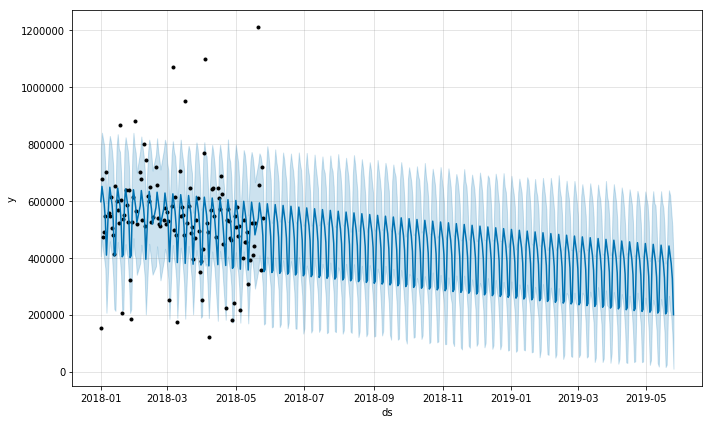

In [97]:
plt = model.plot(forecast)
# too spiky, might try with 7-day-rolling average and reduce to 180 daays

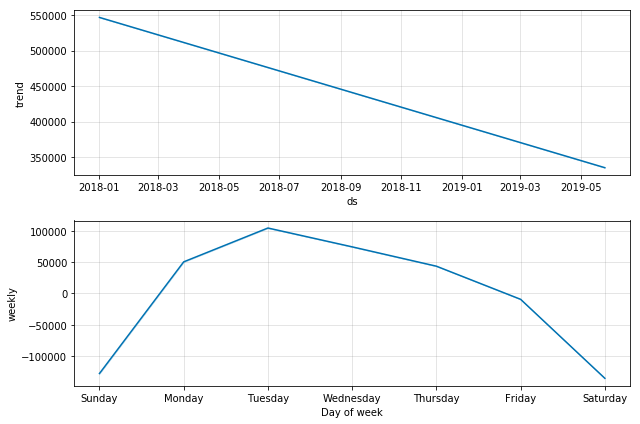

In [98]:
trendplt = model.plot_components(forecast, uncertainty=True)

In [99]:
dffbprophet2 = dfprice[['ds', 'roll_avg']]
dffbprophet2.columns = ['ds', 'y']

In [100]:
model2 = fbprophet.Prophet()
model2.fit(dffbprophet2)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [101]:
future2 = model2.make_future_dataframe(periods=180, include_history=True)
forecast2 = model2.predict(future2)

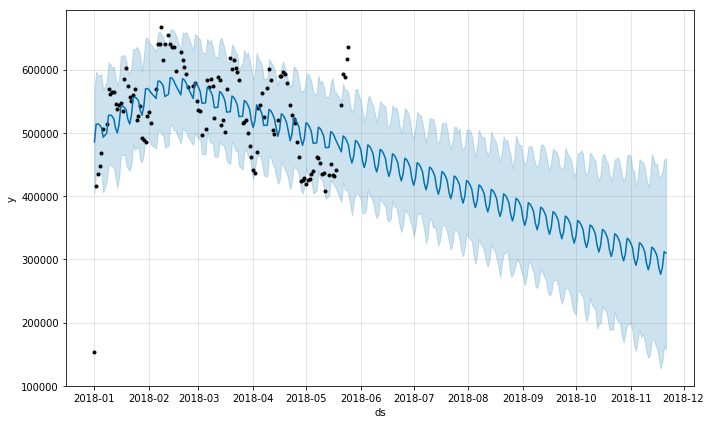

In [105]:
plt2 = model2.plot(forecast2)
# looks a bit better after ignore some noises

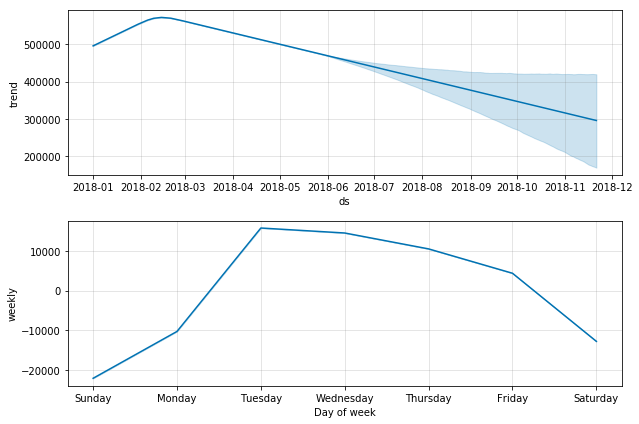

In [104]:
plttrend2 = model2.plot_components(forecast2)

- Check with UK.gov, the average flat price in London June 2018 is £416,101,the model perdict aroun £460,000, which is not bad with the small data set
- The model predict the flat price is gonna be around £300,000, which I think it is a bit absurd